In [1]:
import scipy.ndimage as ndi  # using version 1.2.1
import pandas as pd  # using version 0.24.2
import matplotlib as mpl  # using version 3.0.3
from matplotlib import pyplot as plt

# Uncomment to rebuild matplotlib's font cache so it can find a newly-installed font
#import matplotlib.font_manager
#mpl.font_manager._rebuild()

pd.set_option('display.max_rows', 10)  # concise dataframe display

mpl.rc(
    'font',
    family=['Helvetica', 'Helvetica Neue', 'Helvetica Neue LT Std'],
    weight=500,
    size=24
)
mpl.rc(
    'axes',
    titlesize=36,
    titleweight='medium',
    labelsize=36,
    labelweight='medium',
    titlepad=30,
    labelpad=20,
    linewidth=2,
    xmargin=0.01,
    ymargin=0.01
)
mpl.rc('xtick', labelsize=30)
mpl.rc('xtick.major', pad=10, size=10, width=2)
mpl.rc('ytick', labelsize=24)
mpl.rc('ytick.major', pad=10, size=10, width=2)
mpl.rc(
    'legend',
    fontsize=30,
    handlelength=1,
    fancybox=False,
    borderpad=0.5,
    borderaxespad=0.05,
    framealpha=1
)
mpl.rc(
    'figure',
    dpi=300,
    titlesize=36,
    titleweight='medium'
)
mpl.rc('savefig', dpi=300, transparent=True, bbox='tight')
mpl.rc('pdf', fonttype=42)  # TrueType fonts

mpl.rc('lines', linewidth=5)

# Data Support

In [2]:
fan_smoothing_window = 60  # time width of smoothing wndow

def load_df(df_name):
    df = pd.read_csv(
        df_name,
        usecols=[0, 1, 2, 3, 4, 5, 6]
    )
    df.rename(index=str, columns={  # remove units for easier indexing
        'Time (s)': 'Time',
        'Temperature': 'Thermistor',
        'Error (deg C)': 'Error',
        'Setpoint Reached': 'Reached'
    }, inplace=True)
    df.dropna(how='all', inplace=True)
    df.index = pd.to_timedelta(df['Time'], unit='s')  # set index to units of seconds
    df.Time = df.Time / 60  # set Time to units of minutes
    return df

def smooth_fan(df):
    df['FanSmooth'] = df.Fan.rolling(fan_smoothing_window, win_type='hamming').mean()

# Plotting Support

In [3]:
figure_width = 17.5
figure_temps_height = 4
figure_complete_height = 7.5
figure_complete_height_ratio = (3, 2)
box_width_shrink_factor = 0.875  # to fit the figure legend on the right
ylabel_position = -0.08

min_temp = 20
max_temp = 100

legend_location = 'center right'

reached_color = 'gainsboro'  # light gray
setpoint_color = 'tab:green'
thermistor_color = 'tab:orange'
fan_color = 'tab:blue'
heater_color = 'tab:red'

In [4]:
def fig_temps(title):
    (fig, ax_temp) = plt.subplots(
        figsize=(figure_width, figure_temps_height)
    )
    ax_temp.set_title(title)
    return (fig, ax_temp)

def fig_complete(title):
    (fig, (ax_temp, ax_duties)) = plt.subplots(
        nrows=2, sharex=True,
        gridspec_kw={
            'height_ratios': figure_complete_height_ratio
        },
        figsize=(figure_width, figure_complete_height)
    )
    ax_temp.set_title(title)
    return (fig, (ax_temp, ax_duties))

def plot_setpoint_reached(df, ax, label=True):
    legend_label = 'Reached\nSetpoint'
    if not label:
        legend_label = '_' + legend_label  # hide the label from the legend
    
    (groups, _) = ndi.label(df.Reached.values.tolist())
    df = pd.DataFrame({
        'Time': df.Time,
        'ReachedGroup': groups
    })
    result = (
        df
        .loc[df.ReachedGroup != 0]
        .groupby('ReachedGroup')['Time']
        .agg(['first', 'last'])
    )
    for (i, (group_start, group_end)) in enumerate(result.values.tolist()):
        ax.axvspan(group_start, group_end, facecolor=reached_color, label=legend_label)
        if i == 0:
            legend_label = '_' + legend_label  # hide subsequent labels from the legend
    

def plot_temps(df, ax, label_x=True):
    ax.plot(df.Time, df.Setpoint, color=setpoint_color, label='Setpoint')
    ax.plot(df.Time, df.Thermistor, color=thermistor_color, label='Thermistor')
    
    ax.set_xlim([df.Time[0], df.Time[-1]])
    ax.set_ylim([min_temp, max_temp])
    
    if label_x:
        ax.set_xlabel('Time (min)')
    ax.set_ylabel('Temperature\n(°C)')
    
def plot_efforts(df, ax):
    ax.plot(df.Time, df.FanSmooth, color=fan_color, label='Fan')
    ax.plot(df.Time, df.Heater, color=heater_color, label='Heater')
    
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Duty\nCycle')

def shrink_ax_width(ax, shrink_factor):
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * shrink_factor, box.height])

def fig_plot_complete(df, title):
    (fig, (ax_temp, ax_duties)) = fig_complete(title)
    
    plot_setpoint_reached(df, ax_temp)
    plot_temps(df, ax_temp, label_x=False)
    ax_temp.yaxis.set_label_coords(ylabel_position, 0.5)
    shrink_ax_width(ax_temp, box_width_shrink_factor)
    
    plot_setpoint_reached(df, ax_duties, label=False)
    plot_efforts(df, ax_duties)
    ax_duties.yaxis.set_label_coords(ylabel_position, 0.5)
    shrink_ax_width(ax_duties, box_width_shrink_factor)
    
    fig.legend(loc=legend_location)

def fig_plot_temps(df, title):
    (fig, ax_temp) = fig_temps(title)
    
    plot_setpoint_reached(df, ax_temp)
    plot_temps(df, ax_temp)
    ax_temp.yaxis.set_label_coords(ylabel_position, 0.5)
    shrink_ax_width(ax_temp, box_width_shrink_factor)
    
    fig.legend(loc=legend_location)

# Stepwise Sequence

In [5]:
df_stepwise = load_df('20190117 Thermal Subsystem Testing Data - Fifth Test.csv')
smooth_fan(df_stepwise)
df_stepwise

,Time,Thermistor,Setpoint,Error,Heater,Fan,Reached,FanSmooth
Time,,,,,,,,
00:00:00,0.000000,24.8,30,5.2,0.00,0,False,NaN
00:00:00.560000,0.009333,24.8,30,5.2,0.00,0,False,NaN
00:00:01.050000,0.017500,24.8,30,5.2,0.01,0,False,NaN
00:00:01.550000,0.025833,24.8,30,5.2,0.01,0,False,NaN
00:00:02.050000,0.034167,24.8,30,5.2,0.01,0,False,NaN
...,...,...,...,...,...,...,...,...
00:59:47.010000,59.783500,30.3,30,-0.3,0.00,1,True,0.663546
00:59:47.510000,59.791833,30.2,30,-0.2,0.00,0,True,0.658512
00:59:48.010000,59.800167,30.3,30,-0.3,0.00,1,True,0.655419


'HelveticaNeueLTStd_Md.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Md.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


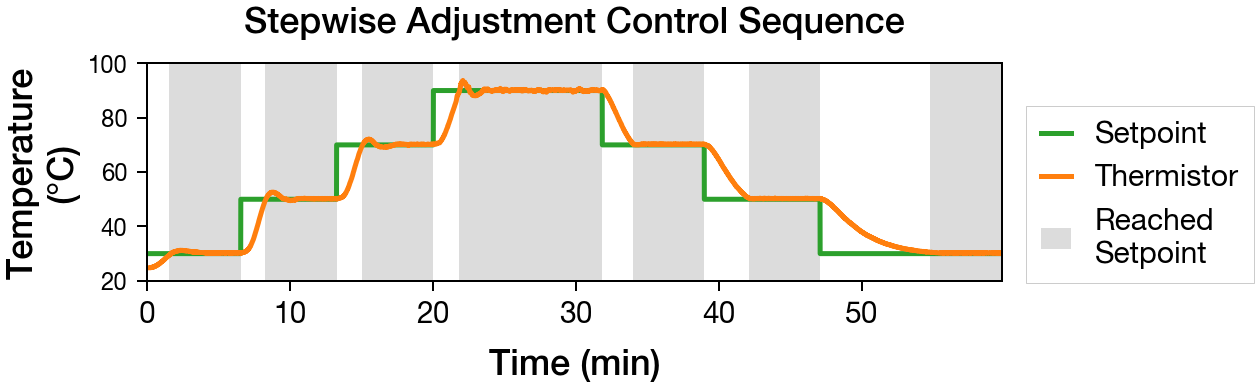

In [6]:
fig_plot_temps(df_stepwise, 'Stepwise Adjustment Control Sequence')
plt.savefig('stepwise_control.pdf', format='pdf')
plt.savefig('stepwise_control.png', format='png')

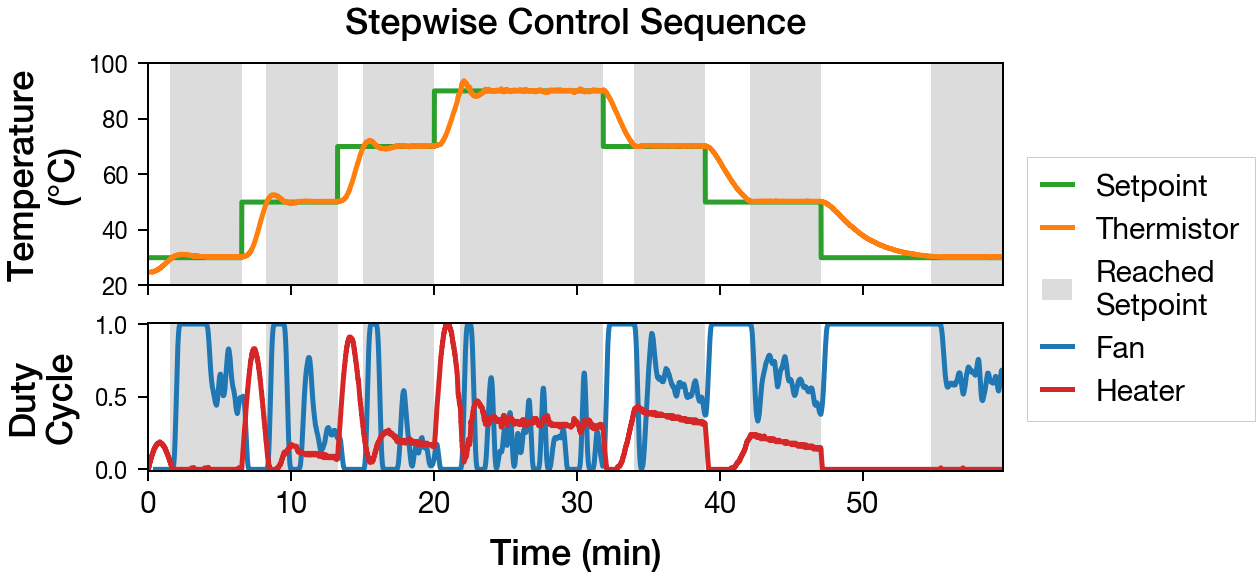

In [7]:
fig_plot_complete(df_stepwise, 'Stepwise Control Sequence')

# Lysis Sequence

In [8]:
df_lysis = load_df('20190117 Thermal Subsystem Testing Data - Fourth Test.csv')
smooth_fan(df_lysis)
df_lysis

,Time,Thermistor,Setpoint,Error,Heater,Fan,Reached,FanSmooth
Time,,,,,,,,
00:00:00,0.000000,24.7,90.0,65.3,0.01,0.0,False,NaN
00:00:00.550000,0.009167,24.7,90.0,65.3,0.05,0.0,False,NaN
00:00:01.050000,0.017500,24.7,90.0,65.3,0.09,0.0,False,NaN
00:00:01.550000,0.025833,24.7,90.0,65.3,0.13,0.0,False,NaN
00:00:02.040000,0.034000,24.7,90.0,65.3,0.17,0.0,False,NaN
...,...,...,...,...,...,...,...,...
00:29:41.030000,29.683833,40.2,40.0,-0.2,0.00,0.0,True,0.040611
00:29:41.530000,29.692167,40.2,40.0,-0.2,0.00,0.0,True,0.043529
00:29:42.020000,29.700333,40.2,40.0,-0.2,0.00,0.0,True,0.046338


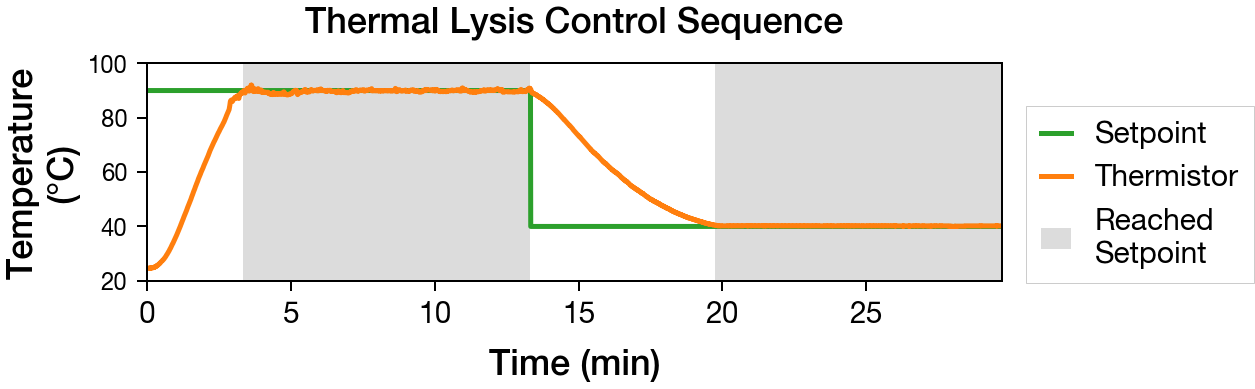

In [9]:
fig_plot_temps(df_lysis, 'Thermal Lysis Control Sequence')

'HelveticaNeueLTStd_Md.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Md.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'HelveticaNeueLTStd_Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


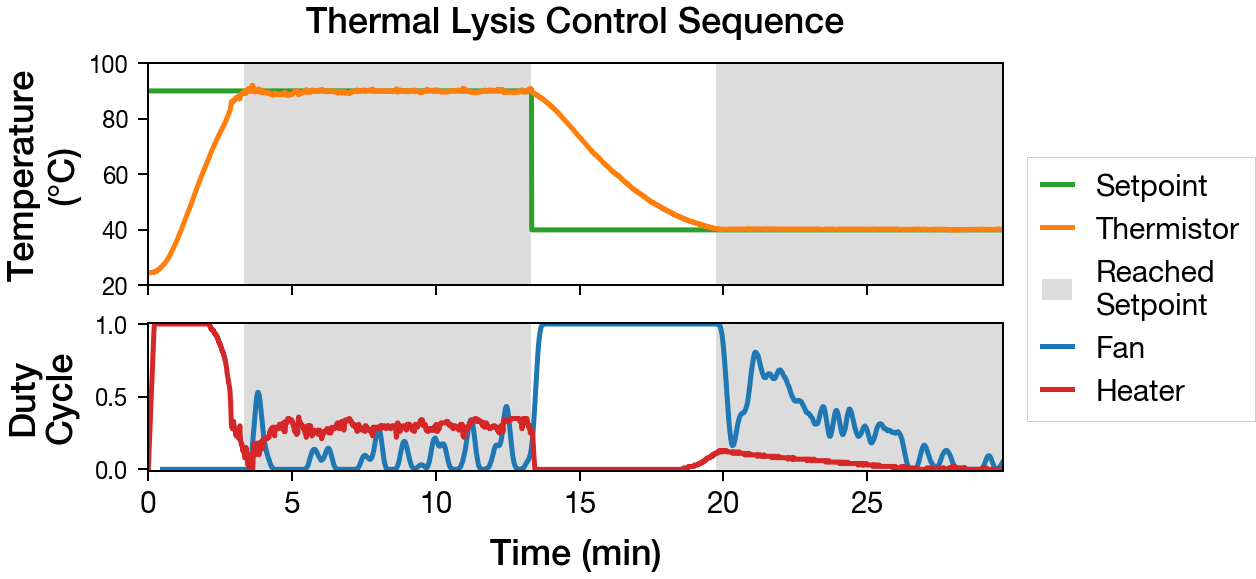

In [10]:
fig_plot_complete(df_lysis, 'Thermal Lysis Control Sequence')
plt.savefig('thermal_lysis.pdf', format='pdf')
plt.savefig('thermal_lysis.png', format='png')